# IMPORTS

Por incompatibilidades entre librerias nos vemos obligados a hacer este workaround para que solucionar los problemas de dependencias.

In [1]:
import  scipy.signal.signaltools
import numpy as np

def _centered(arr, newsize):
    # Return the center newsize portion of the array.
    newsize = np.asarray(newsize)
    currsize = np.array(arr.shape)
    startind = (currsize - newsize) // 2
    endind = startind + newsize
    myslice = [slice(startind[k], endind[k]) for k in range(len(endind))]
    return arr[tuple(myslice)]

scipy.signal.signaltools._centered = _centered
import pandas as pd
import matplotlib.pyplot as plt
# import os
# import pickle
import pytorch_forecasting
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters
from pytorch_forecasting import TemporalFusionTransformer, TimeSeriesDataSet
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
import lightning.pytorch as pl
from lightning.pytorch.loggers import TensorBoardLogger
import torch
from pytorch_forecasting.metrics import MAE, SMAPE, PoissonLoss, QuantileLoss, MAPE, MASE
from lightning.pytorch.tuner import Tuner
from scipy.ndimage import gaussian_filter1d
from  scipy.signal.signaltools import _centered
from tft_helper import *

import os
import sys

torch.backends.cudnn.benchmark = True # Enables cuDNN auto-tuner for faster runtime when input sizes are consistent

basepath = os.path.abspath("")  # script directory

sys.path.insert(1, os.path.join(basepath, "..\\"))
from datetime import datetime, timedelta

c:\Users\nicov\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_forecasting\models\base_model.py:30: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [2]:
# %pip install optuna==3.4.0

# PARAMS

In [ ]:
seq_len = 5 #sequence lenght: how many timesteps does a sequence have. For example a week could be considered a single sequence, therefore seq_len would be 5 as as the stock market opens 5 days a week.
pred_len = 10 # prediction lenght: How many timesteps does a prediction sequence have. For example if each prediction is a full week pred_len should be 5 as the stock market opens 5 days a week.
n_prev_len = 100 # Number of previous timesteps to take for inference. 
n_preds = 3 # number of predictions with test data
test_len = pred_len * n_preds  # Number of timesteps to use for test data.
group = "group" # If a same model should predict different stores, indices etc specify how to group them. If theres only one time series the set group col to one full of the same value.
loss = QuantileLoss() # Loss function. 
epochs = 75 # Epochs to train the model.

# Set ts date range
date_start = '2010-01-04' #None #"2023-06-01"
date_end = "2024-7-29"
shift = 1 # How many times to shift values. Useful for using last indicator values (RSI, MACD...) for inference
ts_indicator_params = {
    "moving_average_windows": [5, 10, 20, 50, 100, 200], # Moving averages periods
    "sigma_gaussian_filter": [1,2],
    "n_lags": 10,
                     
                     }
# cols_to_shift = [2:]

# Set training config.
lr_finder = False
grid_search = "random"
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
# logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

# TFT training params.
tft_params =  {"gradient_clip_val": 0.03, "hidden_size": 24, "dropout": 0.25, "hidden_continuous_size": 24, "attention_head_size": 4, "learning_rate": 0.01, "loss": loss, "early_stop_callback": early_stop_callback}


PIB_relevant_countries = ['USA',
 'CHN',
 'EMU',
 'DEU',
 'FRA',
 'GBR',
 'JPN',
 'IND',
 'BRA',
 'CAN',
 'AUS',
 'ITA',
 'KOR',
 'MEX',
 'IDN',
 'SAU',
 'ZAF',
 'TUR',
 'ESP']

# If grid search, set param grid.
# param_grid = {
#     "gradient_clip_val": [0.01, 0.03, 0.05],
#     "hidden_size": [8, 16, 32],
#     "dropout": [0.1, 0.25, 0.4],
#     "hidden_continuous_size": [8, 16, 32],
#     "attention_head_size": [2, 4, 8],
#     "learning_rate": [0.005, 0.01, 0.03],
#     "loss": [loss],
#     "test_len": [test_len],
#     "pred_len": [pred_len],
#     "n_prev_len": [n_prev_len],
# }

param_grid = {
    "gradient_clip_val": [0.01, 0.03, 0.05],
    "hidden_size": [8, 16, 32],
    "dropout": [0.1, 0.2, 0.3],
    "hidden_continuous_size": [16, 64, 128],
    "attention_head_size": [4,8,16],
    "learning_rate": [0.005, 0.01, 0.03],
    "loss": [loss],
    "test_len": [test_len],
    "pred_len": [pred_len],
    "n_prev_len": [n_prev_len],
}

# LOAD DATA

In [4]:
# Load time series data.
df_nasdaq = load_file(file_name="Nasdaq", path="./data/", ftype="csv")
df_nasdaq = investing_preprocessing(df_nasdaq)
df_nasdaq = df_nasdaq.rename(columns={"target": "exog_nasdaq"})

df_ibex35 = load_file(file_name="Datos históricos del IBEX 35", path="./data/", ftype="csv")
df_ibex35 = investing_preprocessing(df_ibex35)
df_ibex35 = df_ibex35.rename(columns={"target": "exog_ibex35"})

df_eustoxx = load_file(file_name="EUStoxx50", path="./data/", ftype="csv")
df_eustoxx = investing_preprocessing(df_eustoxx)
df_eustoxx = df_eustoxx.rename(columns={"target": "exog_eustoxx"})

df_syp500 = load_file(file_name="S&P500", path="./data/", ftype="csv")
df_syp500 = investing_preprocessing(df_syp500)


df = add_ts_as_exog(df_syp500, [df_ibex35, df_nasdaq, df_eustoxx])

Dataset does not contain volume data.


In [5]:
df

,Date,target,open,max,min,var,exog_ibex35,exog_nasdaq,exog_eustoxx
0,2010-01-04,1133.00,1116.60,1133.90,1116.60,1.61,12145.1,1886.70,NaN
1,2010-01-05,1136.50,1132.70,1136.60,1129.70,0.31,12204.4,1888.43,NaN
2,2010-01-06,1137.10,1135.70,1139.20,1134.00,0.05,12222.5,1878.42,NaN
3,2010-01-07,1141.70,1136.30,1142.50,1131.30,0.40,12166.3,1876.72,NaN
4,2010-01-08,1145.00,1140.50,1145.40,1136.20,0.29,12163.0,1892.59,NaN
...,...,...,...,...,...,...,...,...,...
3724,2024-10-21,5853.98,5857.82,5866.92,5824.79,-0.18,11841.1,20361.47,4941.22
3725,2024-10-22,5851.20,5832.70,5863.04,5821.17,-0.05,11832.7,20383.64,4939.31
3726,2024-10-23,5797.42,5834.50,5834.85,5762.41,-0.92,11865.2,20066.96,4922.55
3727,2024-10-24,5809.86,5817.80,5817.80,5784.92,0.21,11839.8,20232.87,4935.45


## ADD INDICATORS


In [6]:
df = add_global_indicators(df, PIB_relevant_countries, date_start, date_end)
df = add_indicators(df, ts_indicator_params, categorical_tendency_vars=True)
df = df.rename(columns={"target": "exog_syp500"})
df = df.rename(columns={"target_smoothed_2": "target"})


c:\Users\nicov\Documents\Github\QuantTrader-TFT\tft_helper.py:1059: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.ffill()


In [7]:
df

,Date,exog_syp500,open,max,min,var,exog_ibex35,exog_nasdaq,exog_eustoxx,AAII_Bullish,...,bullish_rsi,bearish_rsi,bullish_bollinger,bearish_bollinger,bullish_macd,bearish_macd,bullish_atr,bearish_atr,bullish_trend,bearish_trend
0,2010-01-04,1133.00,1116.60,1133.90,1116.60,1.61,12145.1,1886.70,2324.48,0.410000,...,0,0,0,0,0,0,0,0,0,0
1,2010-01-05,1136.50,1132.70,1136.60,1129.70,0.31,12204.4,1888.43,2324.48,0.410000,...,0,0,0,0,1,0,0,0,0,0
2,2010-01-06,1137.10,1135.70,1139.20,1134.00,0.05,12222.5,1878.42,2324.48,0.410000,...,0,0,0,0,1,0,0,0,0,0
3,2010-01-07,1141.70,1136.30,1142.50,1131.30,0.40,12166.3,1876.72,2324.48,0.410000,...,0,0,0,0,1,0,0,0,0,0
4,2010-01-08,1145.00,1140.50,1145.40,1136.20,0.29,12163.0,1892.59,2324.48,0.410000,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3661,2024-07-23,5555.74,5565.30,5585.34,5550.90,-0.16,11212.7,19754.34,4916.80,0.527473,...,0,0,0,0,0,1,1,0,0,0
3662,2024-07-24,5427.13,5505.84,5508.04,5419.98,-2.31,11210.1,19032.39,4861.87,0.527473,...,0,0,0,0,0,1,1,0,0,0
3663,2024-07-25,5399.22,5428.70,5491.59,5390.95,-0.51,11145.6,18830.59,4811.28,0.431734,...,0,0,1,0,0,1,1,0,1,0
3664,2024-07-26,5459.10,5433.67,5488.32,5430.70,1.11,11165.9,19023.66,4862.50,0.431734,...,0,0,0,0,0,1,1,0,0,0


In [8]:
# SHift indicator values
cols_to_shift = [col for col in df.columns[3:] if not (col.startswith('AAII') or col.startswith('PIB'))]
df[cols_to_shift] = df[cols_to_shift].shift(shift)


In [9]:
data = df.copy()
data["group"] = 1

# Supongamos que tu DataFrame se llama 'data' y que la columna 'Date' tiene las fechas
# Crear una lista de días festivos (ejemplo, agrega tus días festivos)
dias_festivos = pd.to_datetime(["2024-01-01", "2024-12-25", ])  # Añade más días festivos

# Meses del año (convertir a nombres de meses)
data["month"] = data["Date"].dt.strftime('%B')  # Ejemplo: "January", "February", etc.

# Días del año (de 1 a 365 o 366 en años bisiestos), convertir en cadena
data["day_of_year"] = data["Date"].dt.dayofyear.astype(str)  # Convertir el número de día a cadena

# Días de la semana (de lunes a viernes: 0 = lunes, 4 = viernes), convertir a nombre de día
data["weekday"] = data["Date"].dt.strftime('%A')  # Ejemplo: "Monday", "Tuesday", etc.

# Filtrar para eliminar sábados y domingos
data = data[data["weekday"].isin(["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"])]

# Identificar si el día es festivo (usar "Yes" o "No" en lugar de 1 o 0)
data["is_holiday"] = data["Date"].isin(dias_festivos).map({True: "Yes", False: "No"})

data["time_idx"] = data.index


 VARIABLES GROUPING

In [10]:
rest=['Date', 'target',
'FEDFUNDS', 'open', 'max', 'min', 'var',
'MACD', 'Signal_Line',
'group', 'month', 'day_of_year', 'weekday','is_holiday', 'time_idx']
PIB_cols = [col for col in df.columns if col.startswith('PIB')]
AAII_cols = [col for col in df.columns if col.startswith('AAII')]
VIX_cols = [col for col in df.columns if col.endswith('VIX')]
SMA_cols = [col for col in df.columns if col.startswith('SMA')]
EMA_cols = [col for col in df.columns if col.startswith('EMA')]
lag_cols = [col for col in df.columns if col.startswith('target_lag')]
target_smoothed_cols = [col for col in df.columns if col.startswith('target_smoothed')]
RSI_cols = [col for col in df.columns if col.startswith('RSI')]
Bollinger_cols = [col for col in df.columns if col.startswith('Bollinger')]
ATR_cols = [col for col in df.columns if col.startswith('ATR')]
CCI_cols = [col for col in df.columns if col.startswith('CCI')]
ROC_cols = [col for col in df.columns if col.startswith('ROC')]
Williams_cols = [col for col in df.columns if col.startswith('Williams')]
Stochastic_cols = [col for col in df.columns if col.startswith('Stochastic')]
bullish_cols = [col for col in df.columns if col.startswith('bullish')]
bearish_cols = [col for col in df.columns if col.startswith('bearish')]
exog_ts = [col for col in df.columns if col.startswith('exog')]

## TRAIN - TEST SPLIT

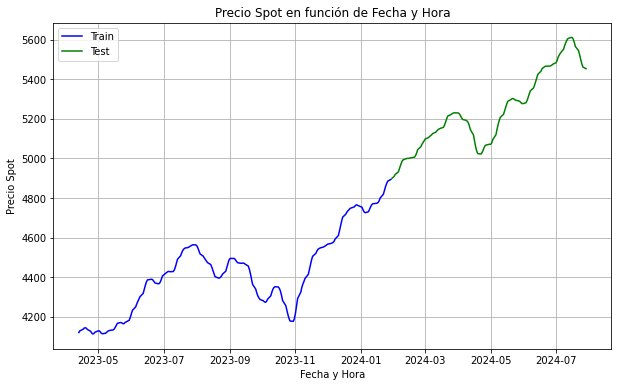

In [11]:
full = data.copy()
cols_to_convert = ["target", "open", "max", "min", "var", "MACD", "Signal_Line"] + SMA_cols + EMA_cols + Bollinger_cols + ATR_cols + CCI_cols + ROC_cols + Williams_cols + Stochastic_cols + exog_ts + VIX_cols + lag_cols + target_smoothed_cols + RSI_cols
full[cols_to_convert] = full[cols_to_convert].apply(pd.to_numeric, errors='coerce')
full = full.ffill().bfill()

data = full[:-test_len]
test = full[-test_len:]
data = data.reset_index(drop=True)
data = data.dropna()


plt.figure(figsize=(10, 6))
plt.plot(data["Date"][-200:], data["target"][-200:], color="blue", label="Train")
plt.plot(test["Date"][-200:], test["target"][-200:], color="green", label="Test")

plt.xlabel("Fecha y Hora")
plt.ylabel("Precio Spot")
plt.title("Precio Spot en función de Fecha y Hora")
plt.legend()
plt.grid(True)
plt.show()

In [12]:
data

,Date,exog_syp500,open,max,min,var,exog_ibex35,exog_nasdaq,exog_eustoxx,AAII_Bullish,...,bullish_atr,bearish_atr,bullish_trend,bearish_trend,group,month,day_of_year,weekday,is_holiday,time_idx
0,2010-01-04,1133.00,1116.60,1133.90,1116.60,1.61,12145.1,1886.70,2324.48,0.410000,...,0,0,0,0,1,January,4,Monday,No,0
1,2010-01-05,1136.50,1132.70,1133.90,1116.60,1.61,12145.1,1886.70,2324.48,0.410000,...,0,0,0,0,1,January,5,Tuesday,No,1
2,2010-01-06,1137.10,1135.70,1136.60,1129.70,0.31,12204.4,1888.43,2324.48,0.410000,...,0,0,0,0,1,January,6,Wednesday,No,2
3,2010-01-07,1141.70,1136.30,1139.20,1134.00,0.05,12222.5,1878.42,2324.48,0.410000,...,0,0,0,0,1,January,7,Thursday,No,3
4,2010-01-08,1145.00,1140.50,1142.50,1131.30,0.40,12166.3,1876.72,2324.48,0.410000,...,0,0,0,0,1,January,8,Friday,No,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3536,2024-01-23,4864.60,4856.80,4868.41,4844.05,0.22,9968.1,17330.38,4480.32,0.403756,...,1,0,1,0,1,January,23,Tuesday,No,3536
3537,2024-01-24,4868.55,4888.56,4866.48,4844.37,0.29,9859.2,17404.21,4465.91,0.403756,...,1,0,1,0,1,January,24,Wednesday,No,3537
3538,2024-01-25,4894.16,4886.66,4903.68,4865.94,0.08,9974.0,17499.30,4564.11,0.392683,...,0,1,0,0,1,January,25,Thursday,No,3538
3539,2024-01-26,4890.97,4888.91,4898.15,4869.34,0.53,9916.6,17516.99,4582.26,0.392683,...,0,1,0,0,1,January,26,Friday,No,3539


<!-- ## DF FINL -->

## TimeSeriesDataset

In [13]:
max_prediction_length = pred_len
max_encoder_length = n_prev_len 
# Ajusta training_cutoff para reservar un rango más amplio para la validación
# validation_size = 50  # ajusta según el tamaño deseado para el conjunto de validación
training_cutoff = data["time_idx"].max() - max_prediction_length #- validation_size

train = TimeSeriesDataSet(
    data[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="target",
    group_ids=[group],
    min_encoder_length=max_encoder_length,  # keep encoder length long (as it is in the validation set)
    max_encoder_length=max_encoder_length,
    # min_prediction_length=24,
    max_prediction_length=max_prediction_length,
    static_categoricals=[],
    static_reals=[],
    time_varying_known_categoricals=["month", "weekday", "day_of_year", "is_holiday"],  # group of categorical variables can be treated as one variable
    time_varying_known_reals=["Date", "time_idx", 'FEDFUNDS'] + AAII_cols + PIB_cols,
                                        
    time_varying_unknown_categoricals=  bullish_cols +  bearish_cols,
    time_varying_unknown_reals=[
        "target",
        "open",
        "max",
        "min",
        # "vol",
        "var",
        "MACD",
        "Signal_Line",
    ]     + 
    lag_cols + 
    SMA_cols +
    EMA_cols +
    RSI_cols +
    Bollinger_cols +
    ATR_cols +
    CCI_cols +
    ROC_cols +
    Stochastic_cols +
    Williams_cols +
    VIX_cols +
    exog_ts +
    target_smoothed_cols
    ,
    # lags={"target": list(range(1, 5))},
    # target_normalizer=GroupNormalizer("standard", groups=[group], transformation="softplus"),
    # use softplus and normalize by group
    add_relative_time_idx=True,
    add_target_scales=True,
    allow_missing_timesteps=True,
    # add_encoder_length=True,
    categorical_encoders={
        "month": pytorch_forecasting.data.encoders.NaNLabelEncoder(add_nan=True),
        "weekday": pytorch_forecasting.data.encoders.NaNLabelEncoder(add_nan=True),
        "day_of_year": pytorch_forecasting.data.encoders.NaNLabelEncoder(add_nan=True),
    },
)

validation = TimeSeriesDataSet.from_dataset(train,  data, predict=True, stop_randomization=True)
# test = TimeSeriesDataSet.from_dataset(training, test_data, predict=True, stop_randomization=True)

# create dataloaders for model
batch_size = 32  # set this between 32 to 128
train_dataloader = train.to_dataloader(
    train=True, batch_size=batch_size, num_workers=7, persistent_workers=True
)
val_dataloader = validation.to_dataloader(
    train=False, batch_size=batch_size, num_workers=7, persistent_workers=True
)
# test_dataloader = test.to_dataloader(train=False, batch_size=batch_size, num_workers=11, persistent_workers=True)

In [14]:
validation_data = data[lambda x: x.time_idx > training_cutoff]
print(len(validation_data))

25


In [15]:
validation

TimeSeriesDataSet[length=1](
	time_idx='time_idx',
	target='target',
	group_ids=['group'],
	weight=None,
	max_encoder_length=100,
	min_encoder_length=100,
	min_prediction_idx=0,
	min_prediction_length=25,
	max_prediction_length=25,
	static_categoricals=[],
	static_reals=['target_center', 'target_scale'],
	time_varying_known_categoricals=['month', 'weekday', 'day_of_year', 'is_holiday'],
	time_varying_known_reals=['Date', 'time_idx', 'FEDFUNDS', 'AAII_Bullish', 'AAII_Neutral', 'AAII_Bearish', 'PIB_USA', 'PIB_CHN', 'PIB_EMU', 'PIB_DEU', 'PIB_FRA', 'PIB_GBR', 'PIB_JPN', 'PIB_IND', 'PIB_BRA', 'PIB_CAN', 'PIB_AUS', 'PIB_ITA', 'PIB_KOR', 'PIB_MEX', 'PIB_IDN', 'PIB_SAU', 'PIB_ZAF', 'PIB_TUR', 'PIB_ESP', 'relative_time_idx'],
	time_varying_unknown_categoricals=['bullish_sma_50_200', 'bullish_rsi', 'bullish_bollinger', 'bullish_macd', 'bullish_atr', 'bullish_trend', 'bearish_sma_50_200', 'bearish_rsi', 'bearish_bollinger', 'bearish_macd', 'bearish_atr', 'bearish_trend'],
	time_varying_unknown_r


# LEARNIG RATE FINDER

En primer lugar realizamos un estudio para hallar de forma aproximada el valor optimo de tasa de aprendizaje.  No es recomendable al 100% usar el valor sugerido directamente pues a veces no encuentra el mejor, sin embargo si que da un muy buen punto de partida por donde empezar a probar. Para ello usamos un modelo TFT cualquiera basico.

In [16]:
if lr_finder:
    res = get_best_lr(train, train_dataloader, val_dataloader, **tft_params)


# MODELLING

## TRAIN MODEL

In [17]:
if not grid_search:
    # tft_params["learning_rate"] = 0.01
    tft, val_loss = tft_trainer(train, train_dataloader, val_dataloader, max_epochs=epochs, **tft_params)

### EVAL MODEL

In [18]:
if not grid_search:
    preds = tft_predict(tft, val_dataloader)


## GRID SEARCH

In [ ]:
if grid_search == "random":
    # Suprime todos los warnings
    warnings.filterwarnings("ignore")

    # Llamada a la función de búsqueda aleatoria
    best_model, best_params, best_val_loss = random_hyperparameter_search(
        data,
        train,
        train_dataloader,
        val_dataloader,
        test,
        param_grid,
        n_iterations=100,
        max_epochs=50,
        save_dir=f'./plots/gauss_multiexog_syp500_-{n_prev_len}d-{date_start.replace("-","")}-{date_end.replace("-","")}-lessFilters',
        csv_file=f"./results/gauss_multiexog_syp500_-{n_prev_len}d-{date_start}-{date_end}.csv",
    )

Combinación ya probada, saltando: {'gradient_clip_val': 0.05, 'hidden_size': 32, 'dropout': 0.2, 'hidden_continuous_size': 16, 'attention_head_size': 16, 'learning_rate': 0.005, 'loss': QuantileLoss(quantiles=[0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 0.98]), 'test_len': 125, 'pred_len': 25, 'n_prev_len': 100}

 -------------------------------------------------------- 
 Probando combinación aleatoria 2/100: {'gradient_clip_val': 0.05, 'hidden_size': 16, 'dropout': 0.3, 'hidden_continuous_size': 128, 'attention_head_size': 4, 'learning_rate': 0.03, 'loss': QuantileLoss(quantiles=[0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 0.98]), 'test_len': 125, 'pred_len': 25, 'n_prev_len': 100}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 49: 100%|██████████| 32/32 [00:30<00:00,  1.05it/s, v_num=325, train_loss_step=8.430, val_loss=40.50, train_loss_epoch=9.260]      

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 32/32 [00:32<00:00,  0.99it/s, v_num=325, train_loss_step=8.430, val_loss=40.50, train_loss_epoch=9.260]
Number of parameters in network: 554.4k
Training time: 979m 27s


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True


Nueva mejor combinación encontrada: {'gradient_clip_val': 0.05, 'hidden_size': 16, 'dropout': 0.3, 'hidden_continuous_size': 128, 'attention_head_size': 4, 'learning_rate': 0.03, 'loss': QuantileLoss(quantiles=[0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 0.98]), 'test_len': 125, 'pred_len': 25, 'n_prev_len': 100} con pérdida 40.4557

 -------------------------------------------------------- 
 Probando combinación aleatoria 3/100: {'gradient_clip_val': 0.05, 'hidden_size': 8, 'dropout': 0.1, 'hidden_continuous_size': 64, 'attention_head_size': 8, 'learning_rate': 0.01, 'loss': QuantileLoss(quantiles=[0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 0.98]), 'test_len': 125, 'pred_len': 25, 'n_prev_len': 100}


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 49: 100%|██████████| 32/32 [00:31<00:00,  1.02it/s, v_num=331, train_loss_step=12.40, val_loss=87.90, train_loss_epoch=16.40]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 32/32 [00:32<00:00,  0.99it/s, v_num=331, train_loss_step=12.40, val_loss=87.90, train_loss_epoch=16.40]
Number of parameters in network: 151.1k
Training time: 25m 46s


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



 -------------------------------------------------------- 
 Probando combinación aleatoria 4/100: {'gradient_clip_val': 0.01, 'hidden_size': 8, 'dropout': 0.2, 'hidden_continuous_size': 128, 'attention_head_size': 4, 'learning_rate': 0.005, 'loss': QuantileLoss(quantiles=[0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 0.98]), 'test_len': 125, 'pred_len': 25, 'n_prev_len': 100}
Epoch 49: 100%|██████████| 32/32 [00:32<00:00,  1.00it/s, v_num=337, train_loss_step=25.40, val_loss=131.0, train_loss_epoch=22.90]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 32/32 [00:32<00:00,  0.97it/s, v_num=337, train_loss_step=25.40, val_loss=131.0, train_loss_epoch=22.90]
Number of parameters in network: 264.5k
Training time: 27m 50s


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



 -------------------------------------------------------- 
 Probando combinación aleatoria 5/100: {'gradient_clip_val': 0.03, 'hidden_size': 16, 'dropout': 0.2, 'hidden_continuous_size': 128, 'attention_head_size': 4, 'learning_rate': 0.03, 'loss': QuantileLoss(quantiles=[0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 0.98]), 'test_len': 125, 'pred_len': 25, 'n_prev_len': 100}
Epoch 49: 100%|██████████| 32/32 [00:24<00:00,  1.33it/s, v_num=343, train_loss_step=11.10, val_loss=103.0, train_loss_epoch=11.90]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 32/32 [00:24<00:00,  1.29it/s, v_num=343, train_loss_step=11.10, val_loss=103.0, train_loss_epoch=11.90]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Number of parameters in network: 554.4k
Training time: 22m 4s


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



 -------------------------------------------------------- 
 Probando combinación aleatoria 6/100: {'gradient_clip_val': 0.05, 'hidden_size': 32, 'dropout': 0.3, 'hidden_continuous_size': 16, 'attention_head_size': 16, 'learning_rate': 0.03, 'loss': QuantileLoss(quantiles=[0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 0.98]), 'test_len': 125, 'pred_len': 25, 'n_prev_len': 100}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 49: 100%|██████████| 32/32 [00:25<00:00,  1.24it/s, v_num=349, train_loss_step=7.900, val_loss=42.30, train_loss_epoch=7.470]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 32/32 [00:26<00:00,  1.20it/s, v_num=349, train_loss_step=7.900, val_loss=42.30, train_loss_epoch=7.470]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Number of parameters in network: 317.6k
Training time: 23m 6s


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



 -------------------------------------------------------- 
 Probando combinación aleatoria 7/100: {'gradient_clip_val': 0.05, 'hidden_size': 16, 'dropout': 0.2, 'hidden_continuous_size': 64, 'attention_head_size': 16, 'learning_rate': 0.03, 'loss': QuantileLoss(quantiles=[0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 0.98]), 'test_len': 125, 'pred_len': 25, 'n_prev_len': 100}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 49: 100%|██████████| 32/32 [00:25<00:00,  1.25it/s, v_num=355, train_loss_step=11.70, val_loss=58.00, train_loss_epoch=10.50]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 32/32 [00:26<00:00,  1.20it/s, v_num=355, train_loss_step=11.70, val_loss=58.00, train_loss_epoch=10.50]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Number of parameters in network: 337.4k
Training time: 23m 25s


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



 -------------------------------------------------------- 
 Probando combinación aleatoria 8/100: {'gradient_clip_val': 0.05, 'hidden_size': 8, 'dropout': 0.3, 'hidden_continuous_size': 16, 'attention_head_size': 8, 'learning_rate': 0.03, 'loss': QuantileLoss(quantiles=[0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 0.98]), 'test_len': 125, 'pred_len': 25, 'n_prev_len': 100}
Epoch 49: 100%|██████████| 32/32 [00:27<00:00,  1.17it/s, v_num=361, train_loss_step=14.60, val_loss=45.80, train_loss_epoch=12.60]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 32/32 [00:28<00:00,  1.14it/s, v_num=361, train_loss_step=14.60, val_loss=45.80, train_loss_epoch=12.60]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Number of parameters in network: 66.1k
Training time: 22m 53s


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Combinación ya probada, saltando: {'gradient_clip_val': 0.01, 'hidden_size': 32, 'dropout': 0.1, 'hidden_continuous_size': 128, 'attention_head_size': 16, 'learning_rate': 0.01, 'loss': QuantileLoss(quantiles=[0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 0.98]), 'test_len': 125, 'pred_len': 25, 'n_prev_len': 100}

 -------------------------------------------------------- 
 Probando combinación aleatoria 10/100: {'gradient_clip_val': 0.03, 'hidden_size': 16, 'dropout': 0.1, 'hidden_continuous_size': 128, 'attention_head_size': 16, 'learning_rate': 0.03, 'loss': QuantileLoss(quantiles=[0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 0.98]), 'test_len': 125, 'pred_len': 25, 'n_prev_len': 100}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 49: 100%|██████████| 32/32 [00:29<00:00,  1.08it/s, v_num=367, train_loss_step=7.910, val_loss=9.220, train_loss_epoch=9.740]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 32/32 [00:30<00:00,  1.05it/s, v_num=367, train_loss_step=7.910, val_loss=9.220, train_loss_epoch=9.740]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Number of parameters in network: 554.3k
Training time: 23m 31s


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Nueva mejor combinación encontrada: {'gradient_clip_val': 0.03, 'hidden_size': 16, 'dropout': 0.1, 'hidden_continuous_size': 128, 'attention_head_size': 16, 'learning_rate': 0.03, 'loss': QuantileLoss(quantiles=[0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 0.98]), 'test_len': 125, 'pred_len': 25, 'n_prev_len': 100} con pérdida 9.2243

 -------------------------------------------------------- 
 Probando combinación aleatoria 11/100: {'gradient_clip_val': 0.03, 'hidden_size': 32, 'dropout': 0.2, 'hidden_continuous_size': 16, 'attention_head_size': 8, 'learning_rate': 0.03, 'loss': QuantileLoss(quantiles=[0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 0.98]), 'test_len': 125, 'pred_len': 25, 'n_prev_len': 100}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 49: 100%|██████████| 32/32 [00:27<00:00,  1.17it/s, v_num=373, train_loss_step=8.370, val_loss=26.00, train_loss_epoch=7.420]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 32/32 [00:27<00:00,  1.14it/s, v_num=373, train_loss_step=8.370, val_loss=26.00, train_loss_epoch=7.420]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Number of parameters in network: 317.8k
Training time: 22m 55s


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



 -------------------------------------------------------- 
 Probando combinación aleatoria 12/100: {'gradient_clip_val': 0.01, 'hidden_size': 32, 'dropout': 0.1, 'hidden_continuous_size': 16, 'attention_head_size': 16, 'learning_rate': 0.005, 'loss': QuantileLoss(quantiles=[0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 0.98]), 'test_len': 125, 'pred_len': 25, 'n_prev_len': 100}
Epoch 49: 100%|██████████| 32/32 [00:26<00:00,  1.22it/s, v_num=379, train_loss_step=16.90, val_loss=89.80, train_loss_epoch=16.40]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 32/32 [00:26<00:00,  1.19it/s, v_num=379, train_loss_step=16.90, val_loss=89.80, train_loss_epoch=16.40]
Number of parameters in network: 317.6k
Training time: 23m 23s


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



 -------------------------------------------------------- 
 Probando combinación aleatoria 13/100: {'gradient_clip_val': 0.03, 'hidden_size': 16, 'dropout': 0.1, 'hidden_continuous_size': 128, 'attention_head_size': 4, 'learning_rate': 0.005, 'loss': QuantileLoss(quantiles=[0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 0.98]), 'test_len': 125, 'pred_len': 25, 'n_prev_len': 100}
Epoch 49: 100%|██████████| 32/32 [00:26<00:00,  1.22it/s, v_num=385, train_loss_step=16.70, val_loss=64.10, train_loss_epoch=16.70]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 32/32 [00:26<00:00,  1.19it/s, v_num=385, train_loss_step=16.70, val_loss=64.10, train_loss_epoch=16.70]
Number of parameters in network: 554.4k
Training time: 22m 51s


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



 -------------------------------------------------------- 
 Probando combinación aleatoria 14/100: {'gradient_clip_val': 0.05, 'hidden_size': 32, 'dropout': 0.1, 'hidden_continuous_size': 64, 'attention_head_size': 16, 'learning_rate': 0.03, 'loss': QuantileLoss(quantiles=[0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 0.98]), 'test_len': 125, 'pred_len': 25, 'n_prev_len': 100}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 49: 100%|██████████| 32/32 [00:25<00:00,  1.26it/s, v_num=391, train_loss_step=5.440, val_loss=93.60, train_loss_epoch=5.740]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 32/32 [00:26<00:00,  1.22it/s, v_num=391, train_loss_step=5.440, val_loss=93.60, train_loss_epoch=5.740]
Number of parameters in network: 845.1k
Training time: 23m 54s


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



 -------------------------------------------------------- 
 Probando combinación aleatoria 15/100: {'gradient_clip_val': 0.03, 'hidden_size': 16, 'dropout': 0.2, 'hidden_continuous_size': 128, 'attention_head_size': 8, 'learning_rate': 0.01, 'loss': QuantileLoss(quantiles=[0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 0.98]), 'test_len': 125, 'pred_len': 25, 'n_prev_len': 100}
Epoch 49: 100%|██████████| 32/32 [00:25<00:00,  1.24it/s, v_num=397, train_loss_step=16.70, val_loss=96.50, train_loss_epoch=15.90]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 32/32 [00:26<00:00,  1.21it/s, v_num=397, train_loss_step=16.70, val_loss=96.50, train_loss_epoch=15.90]
Number of parameters in network: 554.3k
Training time: 23m 35s


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



 -------------------------------------------------------- 
 Probando combinación aleatoria 16/100: {'gradient_clip_val': 0.01, 'hidden_size': 16, 'dropout': 0.3, 'hidden_continuous_size': 128, 'attention_head_size': 4, 'learning_rate': 0.005, 'loss': QuantileLoss(quantiles=[0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 0.98]), 'test_len': 125, 'pred_len': 25, 'n_prev_len': 100}
Epoch 49: 100%|██████████| 32/32 [00:26<00:00,  1.19it/s, v_num=403, train_loss_step=16.80, val_loss=85.80, train_loss_epoch=18.70]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 32/32 [00:27<00:00,  1.16it/s, v_num=403, train_loss_step=16.80, val_loss=85.80, train_loss_epoch=18.70]
Number of parameters in network: 554.4k
Training time: 23m 12s


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



 -------------------------------------------------------- 
 Probando combinación aleatoria 17/100: {'gradient_clip_val': 0.01, 'hidden_size': 8, 'dropout': 0.3, 'hidden_continuous_size': 64, 'attention_head_size': 8, 'learning_rate': 0.005, 'loss': QuantileLoss(quantiles=[0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 0.98]), 'test_len': 125, 'pred_len': 25, 'n_prev_len': 100}
Epoch 49: 100%|██████████| 32/32 [00:24<00:00,  1.28it/s, v_num=409, train_loss_step=20.90, val_loss=41.00, train_loss_epoch=20.30]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 32/32 [00:25<00:00,  1.25it/s, v_num=409, train_loss_step=20.90, val_loss=41.00, train_loss_epoch=20.30]
Number of parameters in network: 151.1k
Training time: 23m 31s


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



 -------------------------------------------------------- 
 Probando combinación aleatoria 18/100: {'gradient_clip_val': 0.01, 'hidden_size': 8, 'dropout': 0.3, 'hidden_continuous_size': 128, 'attention_head_size': 16, 'learning_rate': 0.03, 'loss': QuantileLoss(quantiles=[0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 0.98]), 'test_len': 125, 'pred_len': 25, 'n_prev_len': 100}
Epoch 49: 100%|██████████| 32/32 [00:25<00:00,  1.23it/s, v_num=415, train_loss_step=13.20, val_loss=39.10, train_loss_epoch=15.20]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 32/32 [00:26<00:00,  1.20it/s, v_num=415, train_loss_step=13.20, val_loss=39.10, train_loss_epoch=15.20]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Number of parameters in network: 264.4k
Training time: 23m 11s


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



 -------------------------------------------------------- 
 Probando combinación aleatoria 19/100: {'gradient_clip_val': 0.03, 'hidden_size': 8, 'dropout': 0.3, 'hidden_continuous_size': 64, 'attention_head_size': 16, 'learning_rate': 0.005, 'loss': QuantileLoss(quantiles=[0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 0.98]), 'test_len': 125, 'pred_len': 25, 'n_prev_len': 100}
Epoch 49: 100%|██████████| 32/32 [00:26<00:00,  1.22it/s, v_num=421, train_loss_step=22.30, val_loss=31.40, train_loss_epoch=20.10]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 32/32 [00:27<00:00,  1.18it/s, v_num=421, train_loss_step=22.30, val_loss=31.40, train_loss_epoch=20.10]
Number of parameters in network: 151.0k
Training time: 24m 4s


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



 -------------------------------------------------------- 
 Probando combinación aleatoria 20/100: {'gradient_clip_val': 0.03, 'hidden_size': 32, 'dropout': 0.3, 'hidden_continuous_size': 64, 'attention_head_size': 8, 'learning_rate': 0.03, 'loss': QuantileLoss(quantiles=[0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 0.98]), 'test_len': 125, 'pred_len': 25, 'n_prev_len': 100}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 49: 100%|██████████| 32/32 [00:25<00:00,  1.23it/s, v_num=427, train_loss_step=9.000, val_loss=96.60, train_loss_epoch=10.80]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 32/32 [00:26<00:00,  1.20it/s, v_num=427, train_loss_step=9.000, val_loss=96.60, train_loss_epoch=10.80]
Number of parameters in network: 845.2k
Training time: 24m 35s


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



 -------------------------------------------------------- 
 Probando combinación aleatoria 21/100: {'gradient_clip_val': 0.05, 'hidden_size': 16, 'dropout': 0.1, 'hidden_continuous_size': 64, 'attention_head_size': 8, 'learning_rate': 0.03, 'loss': QuantileLoss(quantiles=[0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 0.98]), 'test_len': 125, 'pred_len': 25, 'n_prev_len': 100}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 49: 100%|██████████| 32/32 [00:24<00:00,  1.30it/s, v_num=433, train_loss_step=7.970, val_loss=56.00, train_loss_epoch=8.210]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 32/32 [00:25<00:00,  1.27it/s, v_num=433, train_loss_step=7.970, val_loss=56.00, train_loss_epoch=8.210]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Number of parameters in network: 337.5k
Training time: 23m 25s


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



 -------------------------------------------------------- 
 Probando combinación aleatoria 22/100: {'gradient_clip_val': 0.05, 'hidden_size': 32, 'dropout': 0.1, 'hidden_continuous_size': 128, 'attention_head_size': 16, 'learning_rate': 0.005, 'loss': QuantileLoss(quantiles=[0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 0.98]), 'test_len': 125, 'pred_len': 25, 'n_prev_len': 100}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 49: 100%|██████████| 32/32 [00:26<00:00,  1.22it/s, v_num=439, train_loss_step=14.60, val_loss=144.0, train_loss_epoch=14.30]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 32/32 [00:26<00:00,  1.19it/s, v_num=439, train_loss_step=14.60, val_loss=144.0, train_loss_epoch=14.30]
Number of parameters in network: 1265.4k
Training time: 25m 59s


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



 -------------------------------------------------------- 
 Probando combinación aleatoria 23/100: {'gradient_clip_val': 0.05, 'hidden_size': 8, 'dropout': 0.2, 'hidden_continuous_size': 64, 'attention_head_size': 4, 'learning_rate': 0.03, 'loss': QuantileLoss(quantiles=[0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 0.98]), 'test_len': 125, 'pred_len': 25, 'n_prev_len': 100}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 49: 100%|██████████| 32/32 [00:31<00:00,  1.02it/s, v_num=445, train_loss_step=13.20, val_loss=91.80, train_loss_epoch=13.60]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 32/32 [00:32<00:00,  0.99it/s, v_num=445, train_loss_step=13.20, val_loss=91.80, train_loss_epoch=13.60]
Number of parameters in network: 151.1k
Training time: 24m 29s


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



 -------------------------------------------------------- 
 Probando combinación aleatoria 24/100: {'gradient_clip_val': 0.01, 'hidden_size': 32, 'dropout': 0.3, 'hidden_continuous_size': 16, 'attention_head_size': 16, 'learning_rate': 0.03, 'loss': QuantileLoss(quantiles=[0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 0.98]), 'test_len': 125, 'pred_len': 25, 'n_prev_len': 100}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 46:  81%|████████▏ | 26/32 [00:29<00:06,  0.88it/s, v_num=451, train_loss_step=11.30, val_loss=79.90, train_loss_epoch=11.10]      


Detected KeyboardInterrupt, attempting graceful shutdown ...


In [ ]:
if grid_search == "exhaustive":
    
    # Suprime todos los warnings 

    
    warnings.filterwarnings("ignore")
    
    # Llamada a la función de búsqueda de hiperparámetros
    best_model, best_params, best_val_loss = exhaustive_hyperparameter_search(
        data, train, train_dataloader, val_dataloader, test, param_grid, max_epochs=1
    )

In [ ]:
if grid_search:
    tft_predict(best_model, val_dataloader, n_preds=1)


# TEST EVAL

In [ ]:
def make_preds(
    train,
    test,
    model,
    encoder_lenght,
    test_lenght,
    pred_lenght,
    quantiles: bool = True,
):
    # group = model.output_transformer.groups[0]
    if quantiles:
        try:  # for Quantileloss
            preds = []
            preds_data = pd.concat([train[-encoder_lenght:], test])
            for i in range(0, test_lenght, pred_lenght):
                new_data = preds_data[i : i + encoder_lenght + pred_lenght]
                new_data.loc[:, group] = new_data.iloc[0, new_data.columns.get_loc(group)]
                new_raw_predictions = model.predict(new_data, mode="raw", return_x=True)
                prediction = []
                for i in range(pred_lenght):
                    prediction.append(float(new_raw_predictions.output.prediction[0][i][3]))
                preds.append(prediction)
        except:  # for MQF2DistributionLoss
            preds = []
            preds_data = pd.concat([train[-encoder_lenght:], test])
            for i in range(0, test_lenght, pred_lenght):
                new_data = preds_data[i : i + encoder_lenght + pred_lenght]
                new_data.loc[:, group] = new_data.iloc[0, new_data.columns.get_loc(group)]
                prediction = model.to_prediction(new_raw_predictions.output)[0].flatten().tolist()
                preds.append(prediction)
    else:
        preds = []
        preds_data = pd.concat([train[-encoder_lenght:], test])
        for i in range(0, test_lenght, pred_lenght):
            new_data = preds_data[i : i + encoder_lenght + pred_lenght]
            new_data.loc[:, group] = new_data.iloc[0, new_data.columns.get_loc(group)]
            new_raw_predictions = model.predict(new_data, mode="raw", return_x=True)
            prediction = new_raw_predictions.output.prediction[0].flatten().tolist()
            preds.append(prediction)

    return preds

In [ ]:
# preds = []
# preds_data = pd.concat([data[-n_prev_len:], test])
# # preds_data = preds_data.ffill()
# preds_data["target"] = float(1)
# # preds_data.drop(columns=["target"], inplace=True)
# for i in range(0, test_len, pred_len):
#     new_data = preds_data[i : i + n_prev_len + pred_len]
#     new_data.loc[:, group] = new_data.iloc[0, new_data.columns.get_loc(group)]
#     new_raw_predictions = tft.predict(new_data, mode="raw", return_x=True)
#     prediction = new_raw_predictions.output.prediction[0].flatten().tolist()
#     preds.append(prediction)

In [ ]:
preds = make_preds(
    train=data,
    test=test,
    model=tft,
    encoder_lenght=n_prev_len,
    test_lenght=test_len,
    pred_lenght=pred_len,
    quantiles=True if isinstance(loss, QuantileLoss) else False,
)

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, root_mean_squared_error

dates = test["Date"].to_list()
preds_flat = [item for sublist in preds for item in sublist]

# real_vals = list(data[-n_preds * pred_len :]["target"])
real_vals = test["target"].to_list()

print(f"MAE: {mean_absolute_error(real_vals, preds_flat)}")
print(f"MAPE: {mean_absolute_percentage_error(real_vals, preds_flat)}")
print(f"RMSE: {root_mean_squared_error(real_vals, preds_flat)}")

plt.plot(dates, preds_flat, color="r")
plt.plot(dates, real_vals, color="g")
plt.title("Real vs Preds")
plt.xlabel("Índice")
plt.ylabel("Valor")
plt.show()

: 

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
import matplotlib.dates as mdates

# Convertir las fechas a formato de datetime si no están ya
dates = pd.to_datetime(test["Date"]).to_list()

# Aplanar las predicciones si es necesario
preds_flat = [item for sublist in preds for item in sublist]

# Valores reales
real_vals = test["target"].to_list()

# Métricas de error
print(f"MAE: {mean_absolute_error(real_vals, preds_flat)}")
print(f"MAPE: {mean_absolute_percentage_error(real_vals, preds_flat)}")
print(f"RMSE: {mean_squared_error(real_vals, preds_flat, squared=False)}")

# Gráfico
plt.figure(figsize=(10, 6))
plt.plot(dates, real_vals, color="g", label="Valores Reales")
plt.plot(dates, preds_flat, color="r", label="Predicciones")
plt.title("Valores Reales vs Predicciones")
plt.xlabel("Fecha")
plt.ylabel("Valor (€)")

# Formato de fecha en el eje x
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gcf().autofmt_xdate()  # Rotar fechas para mejor visualización

# Añadir leyenda
plt.legend()

# Mostrar gráfico
plt.show()

: 

In [ ]:
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Supongamos que `preds`, `test`, y `dates` ya están definidos en tu entorno

# Aplanar la lista de predicciones
preds_flat = [item for sublist in preds for item in sublist]

# Convertir los valores reales a una lista
real_vals = test["target"].to_list()

# Lista de fechas (timestamps)


# Calcular el error absoluto medio
print(f"MAE: {mean_absolute_error(real_vals, preds_flat)}")
print(f"MAPE: {mean_absolute_percentage_error(real_vals, preds_flat)}")
print(f"RMSE: {root_mean_squared_error(real_vals, preds_flat)}")
# Crear la gráfica
plt.figure(figsize=(10, 6))
plt.plot(dates, preds_flat, color="r", label="Predicciones", marker="o", linestyle="--")
plt.plot(dates, real_vals, color="g", label="Valores Reales", marker="x", linestyle="-")

# Añadir título y etiquetas
plt.title("Predicciones vs Valores Reales")
plt.xlabel("Fecha")
plt.ylabel("Valor")

# Formatear las fechas en el eje x
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
# plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=6))
plt.gcf().autofmt_xdate()  # Rotar las etiquetas de fecha

# Añadir cuadrícula y leyenda
plt.grid(True)
plt.legend()

# Mostrar la gráfica
plt.show()

: 

# INFERENCE

## Retrain for inference

In [ ]:
features = [
    col for col in data.columns if col != "target"
]  # Columnas de características and col != "Date"

max_prediction_length = pred_len
max_encoder_length = n_prev_len  # 48
# training_cutoff = data["Date"].max() - pd.Timedelta(hours=max_encoder_length)
training_cutoff = data["time_idx"].max() - max_prediction_length

retrain = TimeSeriesDataSet(
    full.dropna()[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="target",
    group_ids=[group],
    min_encoder_length=max_encoder_length,  # keep encoder length long (as it is in the validation set)
    max_encoder_length=max_encoder_length,
    # min_prediction_length=24,
    max_prediction_length=max_prediction_length,
    static_categoricals=[],
    static_reals=[],
    time_varying_known_categoricals=[],  # group of categorical variables can be treated as one variable
    time_varying_known_reals=["Date", "month", "week", "day", "time_idx"],
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=[
        "target",
        "open",
        "max",
        "min",
        "vol",
        "var",
        "SMA_5",
        "EMA_5",
        "SMA_10",
        "EMA_10",
        "SMA_15",
        "EMA_15",
        "SMA_20",
        "EMA_20",
        "RSI_6",
        "RSI_10",
        "RSI_14",
        "Bollinger_Upper_5",
        "Bollinger_Lower_5",
        "Bollinger_Upper_10",
        "Bollinger_Lower_10",
        "Bollinger_Upper_15",
        "Bollinger_Lower_15",
        "Bollinger_Upper_20",
        "Bollinger_Lower_20",
        "MACD",
        "Signal_Line",
        "ATR_5",
        "ATR_10",
        "ATR_15",
        "ATR_20",
        "CCI_5",
        "CCI_10",
        "CCI_15",
        "CCI_20",
        "ROC_10",
        "ROC_14",
        "ROC_20",
        "ROC_50",
        "Stochastic_10_K",
        "Stochastic_10_D",
        "Stochastic_14_K",
        "Stochastic_14_D",
        "Stochastic_20_K",
        "Stochastic_20_D",
        "Stochastic_25_K",
        "Stochastic_25_D",
        "Stochastic_50_K",
        "Stochastic_50_D",
        "Williams_%R_10",
        "Williams_%R_14",
    ],
    # lags={"target": list(range(1, 5))},
    # target_normalizer=GroupNormalizer("standard", groups=[group], transformation="softplus"),
    # use softplus and normalize by group
    add_relative_time_idx=True,
    add_target_scales=True,
    allow_missing_timesteps=True,
    # add_encoder_length=True,
    # categorical_encoders={
    #     "month": pytorch_forecasting.data.encoders.NaNLabelEncoder(add_nan=True),
    #     "week": pytorch_forecasting.data.encoders.NaNLabelEncoder(add_nan=True),
    #     "day": pytorch_forecasting.data.encoders.NaNLabelEncoder(add_nan=True),
    # },
)

revalidation = TimeSeriesDataSet.from_dataset(retrain, full.dropna(), predict=True, stop_randomization=True)

# test = TimeSeriesDataSet.from_dataset(training, test_data, predict=True, stop_randomization=True)


# create dataloaders for model

batch_size = 64  # set this between 32 to 128

retrain_dataloader = retrain.to_dataloader(

    train=True, batch_size=batch_size, num_workers=7, persistent_workers=True

)

reval_dataloader = revalidation.to_dataloader(

    train=False, batch_size=batch_size, num_workers=7, persistent_workers=True

)

# test_dataloader = test.to_dataloader(train=False, batch_size=batch_size, num_workers=11, persistent_workers=True)

if not grid_search:

    # tft_params["learning_rate"] = 0.01

    retft, val_loss = tft_trainer(

        retrain, retrain_dataloader, reval_dataloader, max_epochs=epochs, **tft_params

    )

: 

In [ ]:
encoder_data = full[-n_prev_len:]
last_row = full.iloc[-1]
# Creamos nuevas filas
new_rows = []
for i in range(1, 6):
    new_row = last_row.copy()
    new_row["Date"] += timedelta(days=i)
    new_row["day"] += i
    new_row["time_idx"] += i
    new_rows.append(new_row)

# Concatenamos las nuevas filas al DataFrame original
decoder_data = pd.DataFrame(new_rows)

new_data = pd.concat([encoder_data, decoder_data], ignore_index=True)
new_data.loc[:, group] = new_data.iloc[0, new_data.columns.get_loc(group)]
# new_data.loc[-pred_len: ,"target"] = 1
new_raw_predictions = retft.predict(new_data, mode="raw", return_x=True)
if isinstance(loss, QuantileLoss):
    prediction = []
    for i in range(pred_len):
        prediction.append(float(new_raw_predictions.output.prediction[0][i][3]))
else:
    prediction = new_raw_predictions.output.prediction[0].flatten().tolist()
prediction

: 

In [ ]:
# prediction = [11233.22265625, 11129.837890625, 11228.3486328125, 11315.59375, 11555.85546875]
last_vals = full[-10:]
last_vals = last_vals[["Date", "target"]]
fechas_azul = pd.date_range(start="2024-08-26", periods=len(prediction))
predictions = pd.DataFrame({"Date": fechas_azul, "target": prediction})

plt.plot(predictions["Date"], predictions["target"], color="r")
plt.plot(last_vals["Date"], last_vals["target"], color="g")
plt.title("Gráfica de la lista aplanada")
plt.xlabel("Índice")
plt.ylabel("Valor")
plt.show()

: 

# INTERPRETABILITY

In [ ]:
interpretation = tft.interpret_output(preds.output, reduction="sum") #
tft.plot_interpretation(interpretation)


: 

: 